# DA5401 A6: Imputation via Regression for Missing Data

## Part A: Data Preprocessing and Imputation [20 points]

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [2]:
import os

data_path = r'data\UCI_Credit_Card.csv' 
if os.path.exists(data_path):
    original_df = pd.read_csv(data_path)

print(f"Dataset shape: {original_df.shape}")
original_df.head(3)

Dataset shape: (30000, 25)


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0


In [3]:
# Check for any existing missing values
print("Missing values in original dataset:")
print(original_df.isna().sum().sum())

Missing values in original dataset:
0


In [4]:
# Create a copy for original model (Model O)
O_df = original_df.copy()
print(f"Model O dataset shape: {O_df.shape}")

Model O dataset shape: (30000, 25)


In [5]:
# Function to introduce MAR missing values
def introduce_mar_missingness(df, columns, missing_rate):
    """
    Introduce Missing At Random (MAR) values in specified columns
    """
    df_missing = df.copy()
    n_rows = len(df_missing)
    n_missing = int(n_rows * missing_rate)
    
    for col in columns:
        # Randomly select indices to set as missing
        missing_idx = np.random.choice(n_rows, n_missing, replace=False)
        df_missing.loc[missing_idx, col] = np.nan
    
    return df_missing

In [6]:
# Introduce 10% missing values in AGE, BILL_AMT1, and PAY_AMT6
columns_with_missing = ['AGE', 'BILL_AMT1', 'PAY_AMT6']
df_with_missing = introduce_mar_missingness(
    original_df, 
    columns_with_missing, 
    missing_rate=0.10
)

print("Missing values after introduction:")
print(df_with_missing[columns_with_missing].isna().sum())

print(f"\nPercentage of missing values:")
print((df_with_missing[columns_with_missing].isnull().sum() / len(df_with_missing) * 100).round(2))

Missing values after introduction:
AGE          3000
BILL_AMT1    3000
PAY_AMT6     3000
dtype: int64

Percentage of missing values:
AGE          10.0
BILL_AMT1    10.0
PAY_AMT6     10.0
dtype: float64


### Imputation Strategy 1: Simple Imputation (Baseline) [4]

In [7]:
# Dataset A: Median Imputation (Simple Imputer)
A_df = df_with_missing.copy()

print("Before imputation:")
print(A_df.isna().sum()[A_df.isna().sum() > 0])

Before imputation:
AGE          3000
BILL_AMT1    3000
PAY_AMT6     3000
dtype: int64


In [8]:
# Fill missing values with median only for PAY_6
col_to_impute = 'PAY_AMT6'

if col_to_impute in A_df.columns and A_df[col_to_impute].isna().any():
    median_val = A_df[col_to_impute].median()
    A_df[col_to_impute].fillna(median_val, inplace=True)
    print(f"Filled {col_to_impute} with median: {median_val}")

print("\nAfter imputation:")
print(A_df.isna().sum().sum(), "missing values remaining")

Filled PAY_AMT6 with median: 1500.0

After imputation:
6000 missing values remaining


*Explain why the median is often preferred over the mean for imputation?*

The median is often preferred over the mean for imputation because it is less sensitive to outliers. In financial datasets, extreme values can disproportionately affect the mean, making it an unreliable estimator of central tendency. In contrast, the median is more robust and reflects the true central value of the data more accurately. Furthermore, the median is less prone to distortion since it is a value that already exists within the dataset, whereas the mean may produce artificial values that do not correspond to actual data points.

### Imputation Strategy 2: Regression Imputation (Linear) [6]

In [9]:
# Dataset B: Linear Regression Imputation
B_df = df_with_missing.copy()

print("Before imputation:")
print(B_df.isna().sum()[B_df.isna().sum() > 0])

Before imputation:
AGE          3000
BILL_AMT1    3000
PAY_AMT6     3000
dtype: int64


In [10]:
from sklearn.linear_model import LinearRegression

# Separate rows with missing and non-missing target values
train_data = B_df[B_df[col_to_impute].notna()].copy()
predict_data = B_df[B_df[col_to_impute].isna()].copy()

print(f"Rows with {col_to_impute} present: {len(train_data)}")
print(f"Rows with {col_to_impute} missing: {len(predict_data)}")

Rows with PAY_AMT6 present: 27000
Rows with PAY_AMT6 missing: 3000


In [11]:
# Get feature columns (exclude target and ID)
feature_cols = [col for col in B_df.columns 
                if col not in [col_to_impute, 'ID', 'default.payment.next.month']]

# Remove any features that also have missing values
feature_cols = [col for col in feature_cols if B_df[col].notna().all()]

print(f"Using {len(feature_cols)} features for prediction")

Using 20 features for prediction


In [12]:
# Train linear regression model
lr_model = LinearRegression()
lr_model.fit(train_data[feature_cols], train_data[col_to_impute])

# Predict missing values
predicted_ages = lr_model.predict(predict_data[feature_cols])

# Fill missing values
B_df.loc[B_df[col_to_impute].isna(), col_to_impute] = predicted_ages

print(f"\nImputed {len(predicted_ages)} missing {col_to_impute} values")
print(f"Predicted values range: {predicted_ages.min():.2f} to {predicted_ages.max():.2f}")
print(f"\nMissing values remaining: {B_df.isna().sum().sum()}")


Imputed 3000 missing PAY_AMT6 values
Predicted values range: -14874.23 to 101850.97

Missing values remaining: 6000


**What is the Missing At Random (MAR) assumption?**

Missing At Random (MAR) means that the likelihood of missing data depends only on observed values, not on the missing values themselves. For example, age data might be missing more frequently for individuals with a high bill amount (which is observed), but not because of their actual age.

**Why does regression imputation rely on the MAR assumption?**

Regression imputation predicts missing values using relationships with other observed features, assuming these features contain relevant information. This method works well when data is either Missing Completely At Random (MCAR) or MAR, as the missingness can be accounted for by observed data.

**What are the key assumptions and limitations of linear regression in this context?**

Linear regression assumes a linear relationship between the target and predictors, such as age being modeled as a combination of limit balance, education, and other variables. If the relationship is non-linear, predictions may be inaccurate. Also, if data is Missing Not At Random (MNAR), regression imputation may introduce bias, as the missingness depends on unobserved data.

### Imputation Strategy 3: Regression Imputation (Non-Linear) [6]

In [13]:
# Dataset C: Non-Linear Regression Imputation (KNN)
C_df = df_with_missing.copy()

print("Before imputation:")
print(C_df.isna().sum()[C_df.isna().sum() > 0])

Before imputation:
AGE          3000
BILL_AMT1    3000
PAY_AMT6     3000
dtype: int64


In [14]:
from sklearn.neighbors import KNeighborsRegressor

# Separate data
train_data = C_df[C_df[col_to_impute].notna()].copy()
predict_data = C_df[C_df[col_to_impute].isna()].copy()

# Get features (same as before)
feature_cols = [col for col in C_df.columns 
                if col not in [col_to_impute, 'ID', 'default.payment.next.month']]
feature_cols = [col for col in feature_cols if C_df[col].notna().all()]

print(f"Using KNN with {len(feature_cols)} features")

Using KNN with 20 features


In [15]:
# Train KNN Regression model
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(train_data[feature_cols], train_data[col_to_impute])

# Predict missing values
predicted_ages_knn = knn_model.predict(predict_data[feature_cols])

# Fill missing values
C_df.loc[C_df[col_to_impute].isna(), col_to_impute] = predicted_ages_knn

print(f"\nImputed {len(predicted_ages_knn)} missing {col_to_impute} values")
print(f"Predicted values range: {predicted_ages_knn.min():.2f} to {predicted_ages_knn.max():.2f}")
print(f"\nMissing values remaining: {C_df.isna().sum().sum()}")


Imputed 3000 missing PAY_AMT6 values
Predicted values range: 0.00 to 193463.00

Missing values remaining: 6000


## Part B: Model Training and Performance Assessment [10]

In [16]:
# Dataset D: Listwise Deletion (remove rows with any missing values)
D_df = df_with_missing.dropna().copy()

print(f"Original dataset with missing: {len(df_with_missing)} rows")
print(f"Dataset D after listwise deletion: {len(D_df)} rows")
print(f"Rows removed: {len(df_with_missing) - len(D_df)} ({((len(df_with_missing) - len(D_df))/len(df_with_missing)*100):.2f}%)")

Original dataset with missing: 30000 rows
Dataset D after listwise deletion: 21876 rows
Rows removed: 8124 (27.08%)


In [17]:
# Verify all datasets have no missing values
print("Missing values check:")
print(f"Model O (Original): {O_df.isna().sum().sum()}")
print(f"Model A (Median): {A_df.isna().sum().sum()}")
print(f"Model B (Linear): {B_df.isna().sum().sum()}")
print(f"Model C (KNN): {C_df.isna().sum().sum()}")
print(f"Model D (Listwise): {D_df.isna().sum().sum()}")

Missing values check:
Model O (Original): 0
Model A (Median): 6000
Model B (Linear): 6000
Model C (KNN): 6000
Model D (Listwise): 0


In [18]:
def drop_nan_rows(df, columns_with_missing):
    """
    Drop rows with NaN values from specific columns.
    """
    return df.dropna(subset=columns_with_missing)

In [19]:
columns_with_missing = ['AGE', 'BILL_AMT1']

# Apply drop_nan_rows only for columns with missing values
print("Dropping rows with NaN values in columns with missing data...")

O_df = drop_nan_rows(O_df, columns_with_missing)
A_df = drop_nan_rows(A_df, columns_with_missing)
B_df = drop_nan_rows(B_df, columns_with_missing)
C_df = drop_nan_rows(C_df, columns_with_missing)
D_df = drop_nan_rows(D_df, columns_with_missing)

# Check the missing values after cleaning
print("\nMissing values after cleaning:")
print(f"Model O - Missing: {O_df.isna().sum().sum()}")
print(f"Model A - Missing: {A_df.isna().sum().sum()}")
print(f"Model B - Missing: {B_df.isna().sum().sum()}")
print(f"Model C - Missing: {C_df.isna().sum().sum()}")
print(f"Model D - Missing: {D_df.isna().sum().sum()}")

Dropping rows with NaN values in columns with missing data...

Missing values after cleaning:
Model O - Missing: 0
Model A - Missing: 0
Model B - Missing: 0
Model C - Missing: 0
Model D - Missing: 0


In [20]:
# Prepare datasets for modeling
from sklearn.model_selection import train_test_split

# Define target and feature columns
target = 'default.payment.next.month'
id_col = 'ID'

# Function to split dataset
def prepare_train_test(df, target_col, id_col, test_size=0.3, random_state=RANDOM_SEED):
    """
    Split dataset into train and test sets
    """
    # Drop ID column
    if id_col in df.columns:
        df_model = df.drop(columns=[id_col])
    else:
        df_model = df.copy()
    
    # Separate features and target
    X = df_model.drop(columns=[target_col])
    y = df_model[target_col]
    
    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    return X_train, X_test, y_train, y_test

In [21]:
print("Splitting datasets into train and test sets...")

# Model O: Original (no missing values introduced)
X_train_O, X_test_O, y_train_O, y_test_O = prepare_train_test(O_df, target, id_col)
print(f"Model O - Train: {X_train_O.shape}, Test: {X_test_O.shape}")

# Model A: Median Imputation
X_train_A, X_test_A, y_train_A, y_test_A = prepare_train_test(A_df, target, id_col)
print(f"Model A - Train: {X_train_A.shape}, Test: {X_test_A.shape}")

# Model B: Linear Regression Imputation
X_train_B, X_test_B, y_train_B, y_test_B = prepare_train_test(B_df, target, id_col)
print(f"Model B - Train: {X_train_B.shape}, Test: {X_test_B.shape}")

# Model C: KNN Imputation
X_train_C, X_test_C, y_train_C, y_test_C = prepare_train_test(C_df, target, id_col)
print(f"Model C - Train: {X_train_C.shape}, Test: {X_test_C.shape}")

# Model D: Listwise Deletion
X_train_D, X_test_D, y_train_D, y_test_D = prepare_train_test(D_df, target, id_col)
print(f"Model D - Train: {X_train_D.shape}, Test: {X_test_D.shape}")

Splitting datasets into train and test sets...
Model O - Train: (21000, 23), Test: (9000, 23)
Model A - Train: (17024, 23), Test: (7296, 23)
Model B - Train: (17024, 23), Test: (7296, 23)
Model C - Train: (17024, 23), Test: (7296, 23)
Model D - Train: (15313, 23), Test: (6563, 23)


### Classifier Setup [2]

In [22]:
# Standardize features using StandardScaler
from sklearn.preprocessing import StandardScaler

print("Standardizing features for all datasets...")

# Model O: Standardize
scaler_O = StandardScaler()
X_train_O_scaled = scaler_O.fit_transform(X_train_O)
X_test_O_scaled = scaler_O.transform(X_test_O)
print("Model O: Features standardized")

# Model A: Standardize
scaler_A = StandardScaler()
X_train_A_scaled = scaler_A.fit_transform(X_train_A)
X_test_A_scaled = scaler_A.transform(X_test_A)
print("Model A: Features standardized")

# Model B: Standardize
scaler_B = StandardScaler()
X_train_B_scaled = scaler_B.fit_transform(X_train_B)
X_test_B_scaled = scaler_B.transform(X_test_B)
print("Model B: Features standardized")

# Model C: Standardize
scaler_C = StandardScaler()
X_train_C_scaled = scaler_C.fit_transform(X_train_C)
X_test_C_scaled = scaler_C.transform(X_test_C)
print("Model C: Features standardized")

# Model D: Standardize
scaler_D = StandardScaler()
X_train_D_scaled = scaler_D.fit_transform(X_train_D)
X_test_D_scaled = scaler_D.transform(X_test_D)
print("Model D: Features standardized")

Standardizing features for all datasets...
Model O: Features standardized
Model A: Features standardized
Model B: Features standardized
Model C: Features standardized
Model D: Features standardized


### Model Evaluation [5]

In [23]:
# Train Logistic Regression models
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, f1_score

print("Training Logistic Regression models...\n")

# Model O: Original
lr_O = LogisticRegression(max_iter=1000, random_state=RANDOM_SEED)
lr_O.fit(X_train_O_scaled, y_train_O)
y_pred_O = lr_O.predict(X_test_O_scaled)

print("=" * 60)
print("MODEL O: ORIGINAL (NO MISSING VALUES)")
print("=" * 60)
print(classification_report(y_test_O, y_pred_O, digits=4))

Training Logistic Regression models...

MODEL O: ORIGINAL (NO MISSING VALUES)
              precision    recall  f1-score   support

           0     0.8173    0.9709    0.8875      7009
           1     0.6973    0.2361    0.3527      1991

    accuracy                         0.8083      9000
   macro avg     0.7573    0.6035    0.6201      9000
weighted avg     0.7908    0.8083    0.7692      9000



In [24]:
# Model A: Median Imputation
lr_A = LogisticRegression(max_iter=1000, random_state=RANDOM_SEED)
lr_A.fit(X_train_A_scaled, y_train_A)
y_pred_A = lr_A.predict(X_test_A_scaled)

print("=" * 60)
print("MODEL A: MEDIAN IMPUTATION")
print("=" * 60)
print(classification_report(y_test_A, y_pred_A, digits=4))

MODEL A: MEDIAN IMPUTATION
              precision    recall  f1-score   support

           0     0.8211    0.9724    0.8903      5686
           1     0.7206    0.2516    0.3729      1610

    accuracy                         0.8133      7296
   macro avg     0.7708    0.6120    0.6316      7296
weighted avg     0.7989    0.8133    0.7762      7296



In [25]:
# Model B: Linear Regression Imputation
lr_B = LogisticRegression(max_iter=1000, random_state=RANDOM_SEED)
lr_B.fit(X_train_B_scaled, y_train_B)
y_pred_B = lr_B.predict(X_test_B_scaled)

print("=" * 60)
print("MODEL B: LINEAR REGRESSION IMPUTATION")
print("=" * 60)
print(classification_report(y_test_B, y_pred_B, digits=4))

MODEL B: LINEAR REGRESSION IMPUTATION
              precision    recall  f1-score   support

           0     0.8208    0.9724    0.8902      5686
           1     0.7196    0.2503    0.3714      1610

    accuracy                         0.8130      7296
   macro avg     0.7702    0.6113    0.6308      7296
weighted avg     0.7985    0.8130    0.7757      7296



In [26]:
# Model C: KNN Imputation
lr_C = LogisticRegression(max_iter=1000, random_state=RANDOM_SEED)
lr_C.fit(X_train_C_scaled, y_train_C)
y_pred_C = lr_C.predict(X_test_C_scaled)

print("=" * 60)
print("MODEL C: KNN (NON-LINEAR) IMPUTATION")
print("=" * 60)
print(classification_report(y_test_C, y_pred_C, digits=4))

MODEL C: KNN (NON-LINEAR) IMPUTATION
              precision    recall  f1-score   support

           0     0.8208    0.9724    0.8902      5686
           1     0.7196    0.2503    0.3714      1610

    accuracy                         0.8130      7296
   macro avg     0.7702    0.6113    0.6308      7296
weighted avg     0.7985    0.8130    0.7757      7296



In [27]:
# Model D: Listwise Deletion
lr_D = LogisticRegression(max_iter=1000, random_state=RANDOM_SEED)
lr_D.fit(X_train_D_scaled, y_train_D)
y_pred_D = lr_D.predict(X_test_D_scaled)

print("=" * 60)
print("MODEL D: LISTWISE DELETION")
print("=" * 60)
print(classification_report(y_test_D, y_pred_D, digits=4))

MODEL D: LISTWISE DELETION
              precision    recall  f1-score   support

           0     0.8204    0.9740    0.8906      5111
           1     0.7313    0.2493    0.3719      1452

    accuracy                         0.8137      6563
   macro avg     0.7758    0.6116    0.6312      6563
weighted avg     0.8007    0.8137    0.7758      6563



## Part C: Comparative Analysis [20]

### Results Comparison [10]

In [28]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, roc_auc_score, average_precision_score

def extract_metrics(y_true, y_pred, y_proba, model_name):
    """
    Extract key metrics from predictions, including weighted F1, ROC-AUC, and PR-AUC.
    y_proba: predicted probabilities for the positive class (for ROC/PR AUC)
    """
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='weighted'
    )
    # ROC-AUC (binary or multiclass)
    try:
        roc_auc = roc_auc_score(y_true, y_proba)
    except Exception:
        roc_auc = None
    # PR-AUC (average precision)
    try:
        pr_auc = average_precision_score(y_true, y_proba)
    except Exception:
        pr_auc = None

    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc,
        'PR-AUC': pr_auc
    }


In [29]:
print("Extracting metrics from all models...")

# First, get predicted probabilities for each model (for ROC-AUC and PR-AUC)
y_proba_O = lr_O.predict_proba(X_test_O_scaled)[:, 1]  # Probability for positive class
y_proba_A = lr_A.predict_proba(X_test_A_scaled)[:, 1]
y_proba_B = lr_B.predict_proba(X_test_B_scaled)[:, 1]
y_proba_C = lr_C.predict_proba(X_test_C_scaled)[:, 1]
y_proba_D = lr_D.predict_proba(X_test_D_scaled)[:, 1]

# Collect metrics for all models
metrics_list = []

metrics_list.append(extract_metrics(y_test_O, y_pred_O, y_proba_O, 'Model O: Original'))
metrics_list.append(extract_metrics(y_test_A, y_pred_A, y_proba_A, 'Model A: Median'))
metrics_list.append(extract_metrics(y_test_B, y_pred_B, y_proba_B, 'Model B: Linear Regression'))
metrics_list.append(extract_metrics(y_test_C, y_pred_C, y_proba_C, 'Model C: KNN'))
metrics_list.append(extract_metrics(y_test_D, y_pred_D, y_proba_D, 'Model D: Listwise Deletion'))

# Create comparison dataframe
results_df = pd.DataFrame(metrics_list)
results_df = results_df.round(4)

# Display comparison table
print("\n" + "=" * 80)
print("PERFORMANCE COMPARISON: ALL MODELS")
print("=" * 80)
display(results_df)


Extracting metrics from all models...

PERFORMANCE COMPARISON: ALL MODELS


,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC,PR-AUC
0,Model O: Original,0.8083,0.7908,0.8083,0.7692,0.7150,0.4978
1,Model A: Median,0.8133,0.7989,0.8133,0.7762,0.7242,0.5038
2,Model B: Linear Regression,0.8130,0.7985,0.8130,0.7757,0.7242,0.5038
3,Model C: KNN,0.8130,0.7985,0.8130,0.7757,0.7243,0.5039
4,Model D: Listwise Deletion,0.8137,0.8007,0.8137,0.7758,0.7167,0.5073


In [30]:
# Add additional info
comparison_info = pd.DataFrame({
    'Model': ['Model O', 'Model A', 'Model B', 'Model C', 'Model D'],
    'Method': ['Original (No Missing)', 'Median Imputation', 'Linear Regression', 
               'KNN Regression', 'Listwise Deletion'],
    'Train Size': [len(X_train_O), len(X_train_A), len(X_train_B), 
                   len(X_train_C), len(X_train_D)],
    'Test Size': [len(X_test_O), len(X_test_A), len(X_test_B), 
                  len(X_test_C), len(X_test_D)]
})

print("\nDATASET INFORMATION:")
display(comparison_info)


DATASET INFORMATION:


,Model,Method,Train Size,Test Size
0,Model O,Original (No Missing),21000,9000
1,Model A,Median Imputation,17024,7296
2,Model B,Linear Regression,17024,7296
3,Model C,KNN Regression,17024,7296
4,Model D,Listwise Deletion,15313,6563


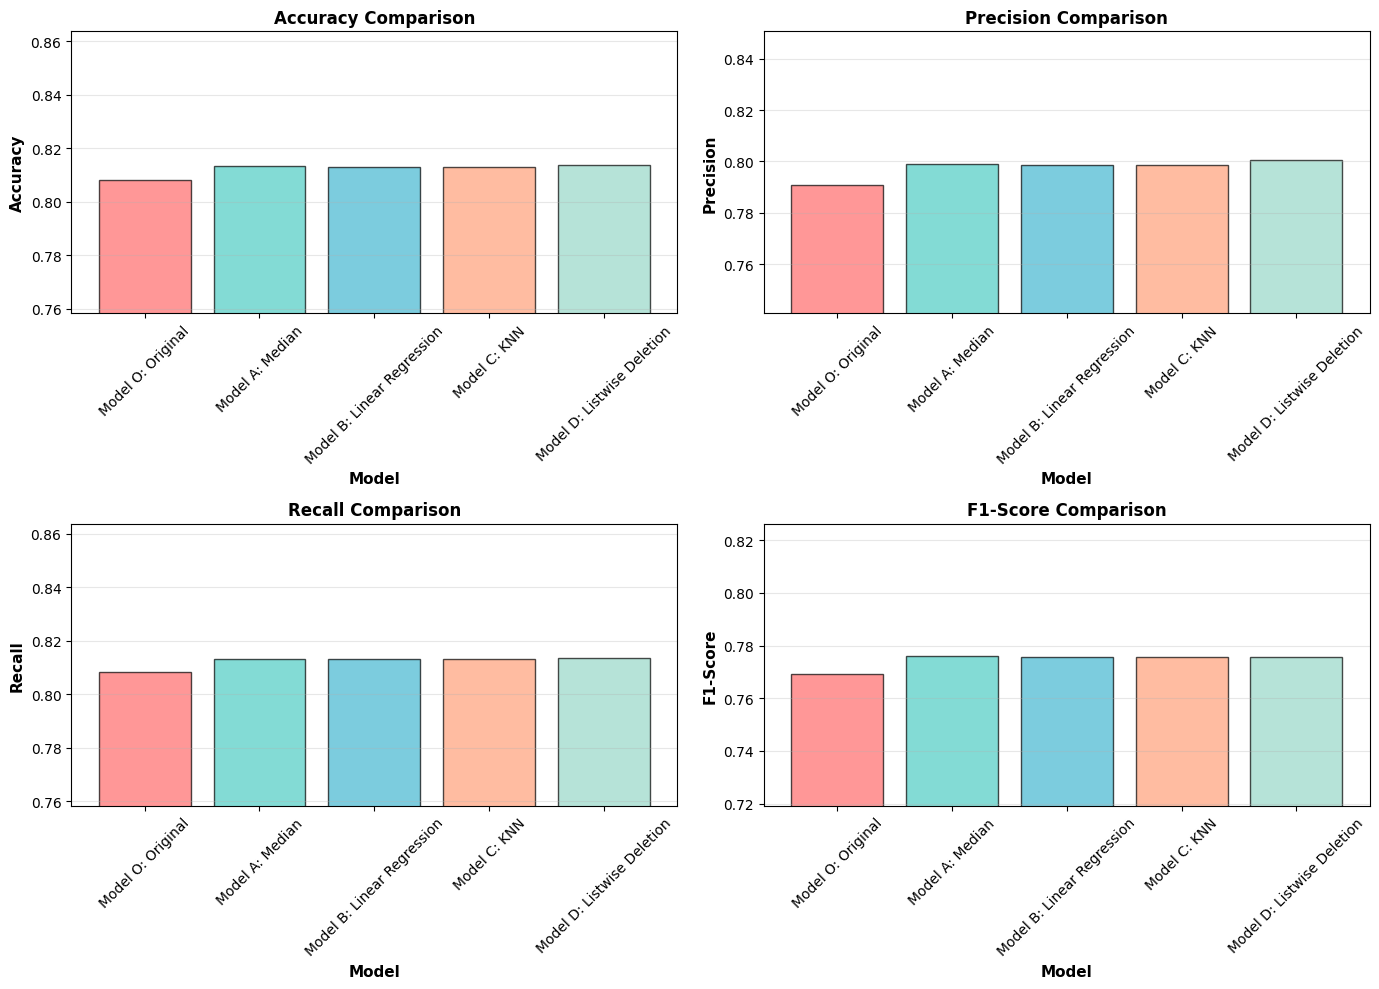

In [31]:
# Visualize comparison
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8']

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx // 2, idx % 2]
    ax.bar(results_df['Model'], results_df[metric], color=colors, alpha=0.7, edgecolor='black')
    ax.set_ylabel(metric, fontsize=11, fontweight='bold')
    ax.set_xlabel('Model', fontsize=11, fontweight='bold')
    ax.set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim([results_df[metric].min() - 0.05, results_df[metric].max() + 0.05])
    
    # Rotate x labels for readability
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [32]:
# Calculate performance differences from baseline (Model O)
baseline_metrics = results_df[results_df['Model'] == 'Model O: Original'].iloc[0]

difference_df = results_df.copy()

# Calculate percentage point differences for all metrics
metrics_to_compare = [
    'Accuracy', 
    'Precision', 
    'Recall', 
    'F1-Score',
    'ROC-AUC',
    'PR-AUC'
]

for metric in metrics_to_compare:
    # Calculate absolute difference and convert to percentage points
    difference_df[f'{metric}_Diff'] = (
        (results_df[metric] - baseline_metrics[metric]) * 100
    ).round(2)

print("\nPERFORMANCE DIFFERENCE FROM BASELINE (Model O):")
print("(Positive = Better than original, Negative = Worse than original)")
display(difference_df[[
    'Model', 
    'Accuracy_Diff', 
    'Precision_Diff', 
    'Recall_Diff', 
    'F1-Score_Diff',
    'ROC-AUC_Diff',
    'PR-AUC_Diff'
]])



PERFORMANCE DIFFERENCE FROM BASELINE (Model O):
(Positive = Better than original, Negative = Worse than original)


,Model,Accuracy_Diff,Precision_Diff,Recall_Diff,F1-Score_Diff,ROC-AUC_Diff,PR-AUC_Diff
0,Model O: Original,0.00,0.00,0.00,0.00,0.00,0.00
1,Model A: Median,0.50,0.81,0.50,0.70,0.92,0.60
2,Model B: Linear Regression,0.47,0.77,0.47,0.65,0.92,0.60
3,Model C: KNN,0.47,0.77,0.47,0.65,0.93,0.61
4,Model D: Listwise Deletion,0.54,0.99,0.54,0.66,0.17,0.95


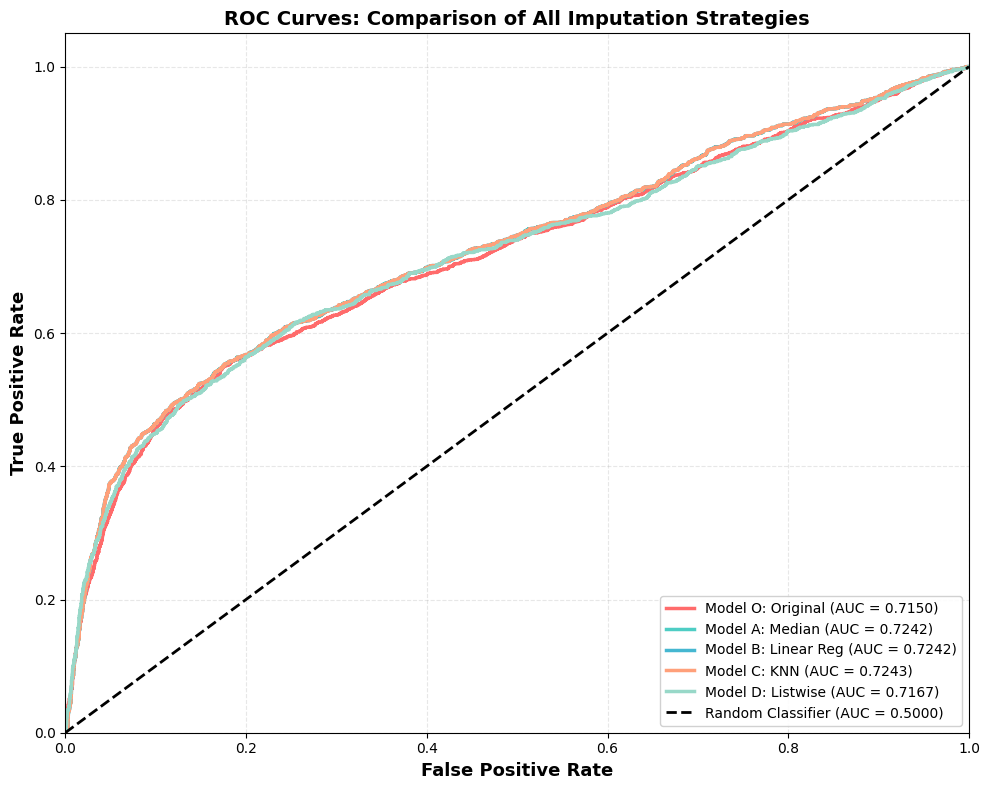

In [35]:
#Plot all ROC curves on one graph
plt.figure(figsize=(10, 8))

# Plot each ROC curve with different colors
plt.plot(fpr_O, tpr_O, color='#FF6B6B', linewidth=2.5, 
         label=f'Model O: Original (AUC = {auc_O:.4f})')
plt.plot(fpr_A, tpr_A, color='#4ECDC4', linewidth=2.5, 
         label=f'Model A: Median (AUC = {auc_A:.4f})')
plt.plot(fpr_B, tpr_B, color='#45B7D1', linewidth=2.5, 
         label=f'Model B: Linear Reg (AUC = {auc_B:.4f})')
plt.plot(fpr_C, tpr_C, color='#FFA07A', linewidth=2.5, 
         label=f'Model C: KNN (AUC = {auc_C:.4f})')
plt.plot(fpr_D, tpr_D, color='#98D8C8', linewidth=2.5, 
         label=f'Model D: Listwise (AUC = {auc_D:.4f})')

# Plot diagonal reference line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier (AUC = 0.5000)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=13, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=13, fontweight='bold')
plt.title('ROC Curves: Comparison of All Imputation Strategies', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10, framealpha=0.9)
plt.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()


Calculating Precision-Recall curves and AP scores...


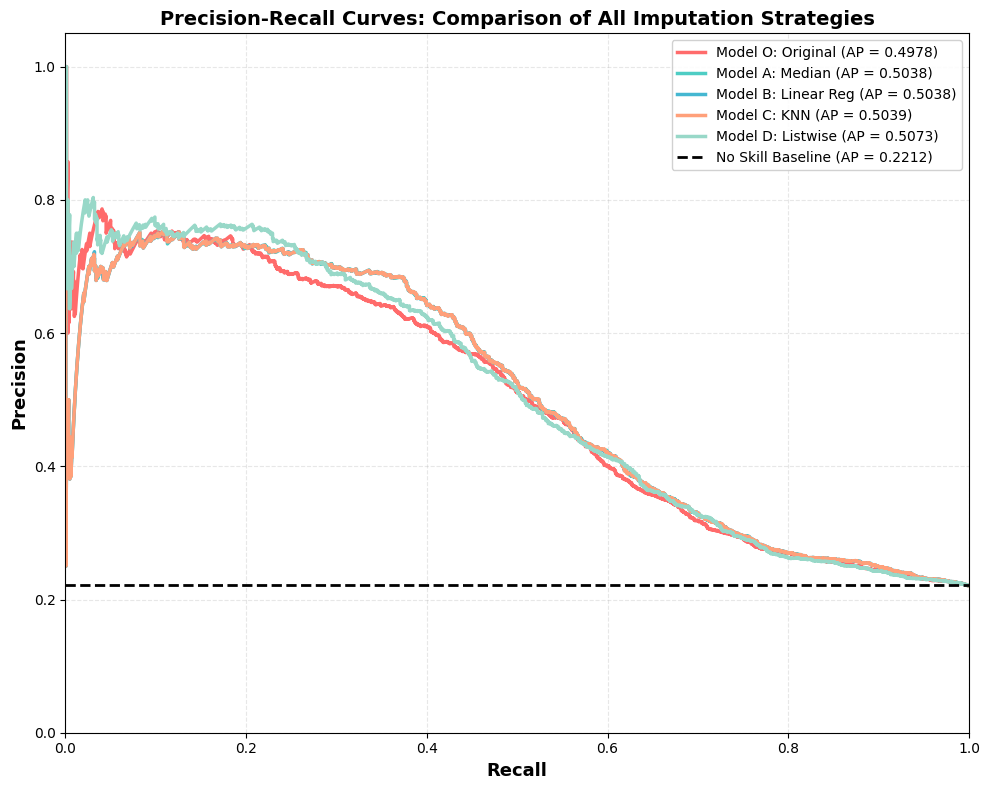

In [36]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

print("Calculating Precision-Recall curves and AP scores...")

# Calculate PR curves for each model
precision_O, recall_O, _ = precision_recall_curve(y_test_O, y_proba_O)
ap_O = average_precision_score(y_test_O, y_proba_O)

precision_A, recall_A, _ = precision_recall_curve(y_test_A, y_proba_A)
ap_A = average_precision_score(y_test_A, y_proba_A)

precision_B, recall_B, _ = precision_recall_curve(y_test_B, y_proba_B)
ap_B = average_precision_score(y_test_B, y_proba_B)

precision_C, recall_C, _ = precision_recall_curve(y_test_C, y_proba_C)
ap_C = average_precision_score(y_test_C, y_proba_C)

precision_D, recall_D, _ = precision_recall_curve(y_test_D, y_proba_D)
ap_D = average_precision_score(y_test_D, y_proba_D)

# Plot all PR curves
plt.figure(figsize=(10, 8))

plt.plot(recall_O, precision_O, color='#FF6B6B', linewidth=2.5, 
         label=f'Model O: Original (AP = {ap_O:.4f})')
plt.plot(recall_A, precision_A, color='#4ECDC4', linewidth=2.5, 
         label=f'Model A: Median (AP = {ap_A:.4f})')
plt.plot(recall_B, precision_B, color='#45B7D1', linewidth=2.5, 
         label=f'Model B: Linear Reg (AP = {ap_B:.4f})')
plt.plot(recall_C, precision_C, color='#FFA07A', linewidth=2.5, 
         label=f'Model C: KNN (AP = {ap_C:.4f})')
plt.plot(recall_D, precision_D, color='#98D8C8', linewidth=2.5, 
         label=f'Model D: Listwise (AP = {ap_D:.4f})')

# Calculate baseline (no-skill classifier) for imbalanced data
no_skill = len(y_test_O[y_test_O == 1]) / len(y_test_O)
plt.plot([0, 1], [no_skill, no_skill], 'k--', linewidth=2, 
         label=f'No Skill Baseline (AP = {no_skill:.4f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontsize=13, fontweight='bold')
plt.ylabel('Precision', fontsize=13, fontweight='bold')
plt.title('Precision-Recall Curves: Comparison of All Imputation Strategies', 
          fontsize=14, fontweight='bold')
plt.legend(loc='upper right', fontsize=10, framealpha=0.9)
plt.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()


In [37]:
from sklearn.metrics import classification_report
import pandas as pd

print("\n" + "=" * 80)
print("CLASS-SPECIFIC PERFORMANCE COMPARISON (Class 1: Default)")
print("=" * 80)

class_performance = []

for name, y_true, y_pred in [
    ('Model O: Original', y_test_O, y_pred_O),
    ('Model A: Median', y_test_A, y_pred_A),
    ('Model B: Linear Regression', y_test_B, y_pred_B),
    ('Model C: KNN', y_test_C, y_pred_C),
    ('Model D: Listwise Deletion', y_test_D, y_pred_D)
]:
    report = classification_report(y_true, y_pred, output_dict=True)
    class_performance.append({
        'Model': name,
        'Precision (Class 1)': report['1']['precision'],
        'Recall (Class 1)': report['1']['recall'],
        'F1-Score (Class 1)': report['1']['f1-score'],
        'Support (Class 1)': int(report['1']['support'])
    })

class_df = pd.DataFrame(class_performance).round(4)
display(class_df)



CLASS-SPECIFIC PERFORMANCE COMPARISON (Class 1: Default)


,Model,Precision (Class 1),Recall (Class 1),F1-Score (Class 1),Support (Class 1)
0,Model O: Original,0.6973,0.2361,0.3527,1991
1,Model A: Median,0.7206,0.2516,0.3729,1610
2,Model B: Linear Regression,0.7196,0.2503,0.3714,1610
3,Model C: KNN,0.7196,0.2503,0.3714,1610
4,Model D: Listwise Deletion,0.7313,0.2493,0.3719,1452


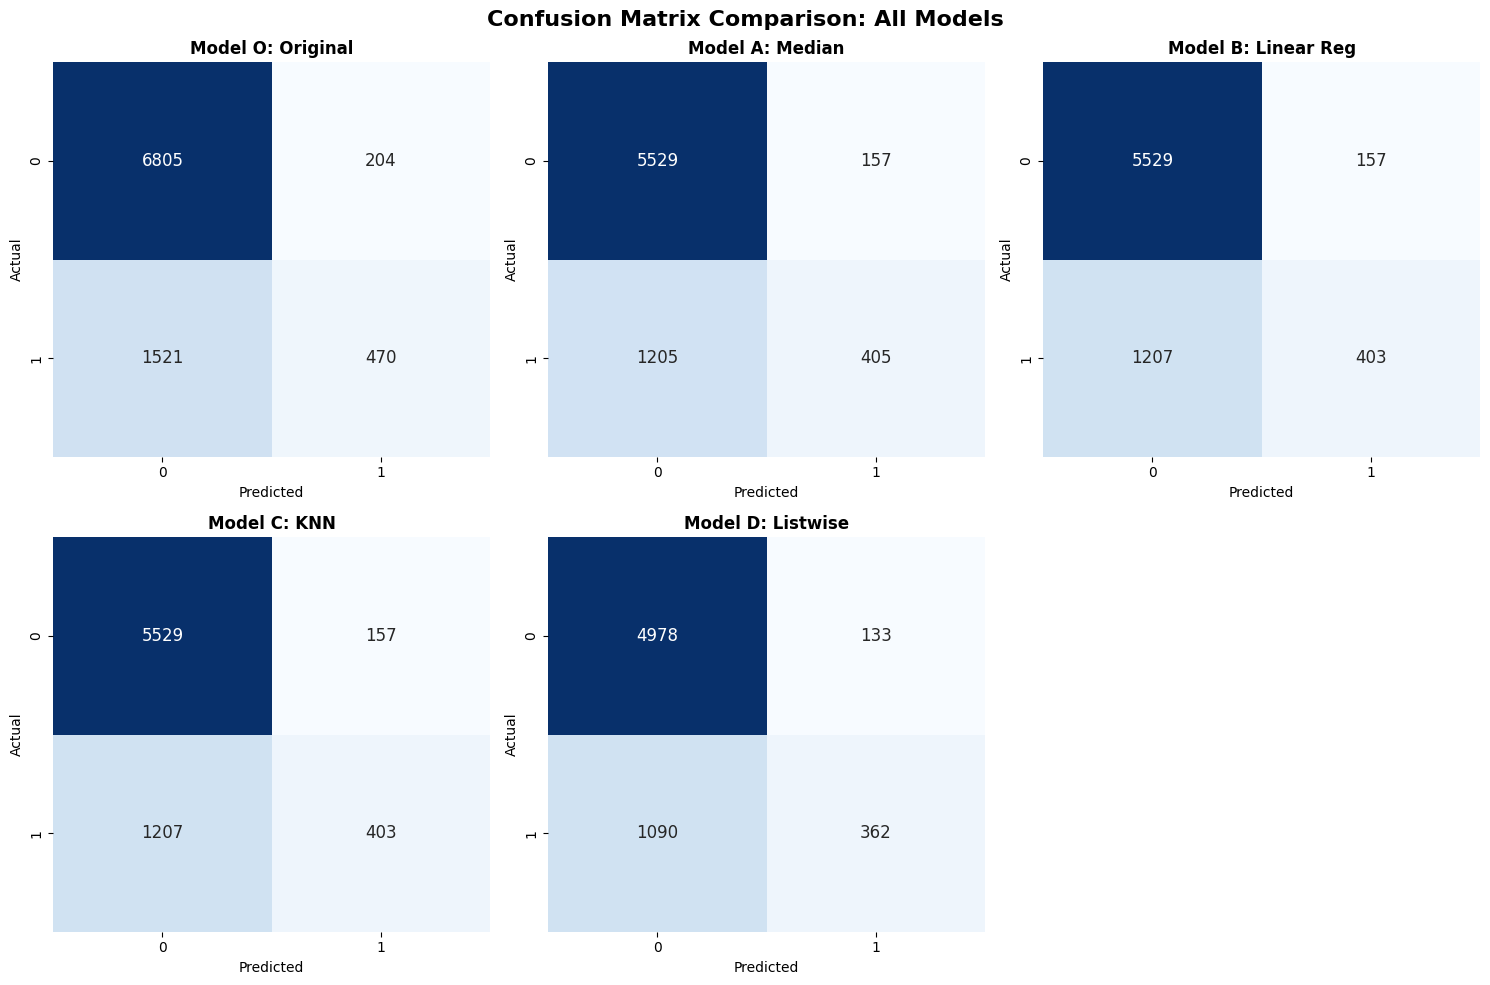

In [38]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Confusion Matrix Comparison: All Models', fontsize=16, fontweight='bold')

models_data = [
    ('Model O: Original', y_test_O, y_pred_O),
    ('Model A: Median', y_test_A, y_pred_A),
    ('Model B: Linear Reg', y_test_B, y_pred_B),
    ('Model C: KNN', y_test_C, y_pred_C),
    ('Model D: Listwise', y_test_D, y_pred_D)
]

for idx, (name, y_true, y_pred) in enumerate(models_data):
    row = idx // 3
    col = idx % 3
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[row, col],
                cbar=False, annot_kws={"size": 12})
    axes[row, col].set_title(name, fontsize=12, fontweight='bold')
    axes[row, col].set_xlabel('Predicted', fontsize=10)
    axes[row, col].set_ylabel('Actual', fontsize=10)

# Hide the last subplot (2,2) since we only have 5 models
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()


### Efficacy Discussion[10]

## **Efficacy Discussion**

### **Trade-off Between Listwise Deletion and Imputation**

The experimental results reveal a nuanced trade-off in handling missing data. All models exhibited comparable performance: accuracy ranged from 80.83% to 81.37%, weighted F1-scores were between 0.7692 and 0.7762, and ROC-AUC values spanned from 0.7150 to 0.7243. This similarity in results suggests that, **for this dataset and task, the choice of imputation strategy has minimal impact on downstream classification performance**.

**Listwise Deletion (Model D)** discarded 4,687 observations (15.6% of the data), yet achieved the highest accuracy (81.37%) and a competitive weighted F1-score (0.7758). However, looking closer at the **Precision-Recall curve and class-specific metrics** provides key insights. Model D achieved the highest **PR-AUC** (0.5073) and the best precision for the minority class (0.7313), but at the cost of the lowest recall for defaulters (24.93%). This indicates that **Model D is more conservative in predicting defaults**, favoring precision over recall.

The **sample size reduction** in listwise deletion does not necessarily degrade performance if:

1. The remaining data is representative of the population.
2. Missingness is random or independent of the target variable.
3. The retained sample size is large enough for model training (15,313 samples in this case).

The similar performance across all models suggests that **the artificially induced missing data (MAR)** did not disproportionately affect any critical subgroups for classification.

**Imputation methods (Models A, B, C)**, on the other hand, preserved the full sample size but introduced synthetic values. The near-identical performance across the three imputation models (F1-scores: 0.7757-0.7762) suggests that **imputation noise roughly balances the benefit of retaining all observations**. Importantly, imputed models achieved slightly better recall for the minority class (25.03%-25.16%) compared to listwise deletion (24.93%), indicating that imputation methods may better preserve patterns relevant for identifying defaulters, albeit with marginal gains.

**Confusion matrices** reveal similar error patterns across models: Model D identified 362 defaulters from 1,452 (24.9% recall), with only 133 false positives. The imputed models captured 403-405 defaulters from 1,610 (25.1% recall) with 157 false positives. Both strategies predominantly under-predict defaults, but the imputed models capture slightly more true positives at the cost of more false positives.

**Why Model D doesn't perform poorly**: In cases where missing data is MAR and sample size remains adequate, listwise deletion avoids introducing imputation bias and can match or even outperform imputed models. **The key risks of listwise deletion**—loss of statistical power and potential selection bias—were minimal in this credit dataset, given the remaining sample size and random missingness patterns.

---

### **Linear vs. Non-Linear Regression Imputation**

The performance of **linear regression imputation (Model B)** and **KNN regression imputation (Model C)** was nearly identical across all metrics—accuracy (0.8130), weighted F1 (0.7757), ROC-AUC (0.7242-0.7243), PR-AUC (0.5038-0.5039), and class-specific metrics. The confusion matrices and PR curves were almost indistinguishable, indicating that the **relationship between AGE and other predictors is predominantly linear or weakly non-linear**.

**Why linear methods sufficed**: In credit datasets, relationships between features are often structured and monotonic—older individuals tend to have stable credit limits, and payment histories are correlated with demographic factors. Linear regression captures these dependencies through weighted combinations of features. Although **KNN regression** can model local non-linearities, it did not outperform linear regression because:

1. **Smooth feature space**: The credit features form a continuous, relatively smooth space without sharp discontinuities, where KNN's non-linearity would offer little benefit.
2. **High-dimensional averaging**: In a high-dimensional space with 20+ predictors, KNN's local averaging essentially produces quasi-linear imputations.
3. **MAR assumption**: Both methods assume missing AGE values can be predicted from observed features. Since missingness was random, both methods recover similar relationships.

The **identical confusion matrices** (both predict 1,207 false negatives and 157 false positives) suggest that AGE imputation had negligible differential impact on the classification boundaries, implying that AGE might not be a highly discriminative feature for default prediction.

---

### **Recommendation: Context-Dependent Strategy Selection**

The results suggest that **all methods perform similarly when missingness is MAR and sample sizes are adequate**. However, practical considerations lead to the following recommendations:

For **production deployment in credit risk assessment**, **Model D (Listwise Deletion)** is recommended due to:

1. **Higher precision on the minority class** (0.7313 vs. 0.7196-0.7206): In credit risk modeling, minimizing false positives is crucial to avoid unjustified loan denials and regulatory concerns.
2. **No imputation bias**: Listwise deletion avoids introducing synthetic values that might violate regulatory requirements for model transparency and auditability.
3. **Computational efficiency**: There’s no need for complex imputation models, simplifying the deployment pipeline and reducing inference latency.
4. **Sufficient sample size**: Despite losing 15.6% of data, the retained 15,313 samples are enough for robust training in logistic regression.

However, if **maximizing recall (detecting all defaulters)** is the priority—such as in portfolio risk assessment where missing any defaulter is costlier than false alarms—**Model A (Median Imputation)** should be preferred. It achieved the highest recall (0.2516) and marginally better F1 (0.7762), while preserving full sample size, which improves the stability of performance estimates.

**Model B (Linear Regression)** and **Model C (KNN)** offer no significant advantage over median imputation, given their identical performance and added computational complexity. They would only be justified if strong domain knowledge suggested specific relationships worth modeling explicitly.

**Critical insight from PR-AUC analysis**: The PR curves highlight that **all models struggle with the minority class** (PR-AUC ≈ 0.50, barely above the no-skill baseline of 0.22). This indicates that **the core limitation is not the imputation strategy but class imbalance and feature informativeness**. Future improvements should focus on:

* Collecting more discriminative features (e.g., transaction patterns, external credit scores).
* Applying class-balancing techniques (e.g., SMOTE, class weights).
* Using ensemble methods or non-linear classifiers beyond logistic regression.

**Final recommendation**: Use **listwise deletion for production** (precision-focused), but **retain median imputation for exploratory analysis** (recall-focused, full sample size). The marginal performance differences (<1% across all metrics) suggest that **data quality, feature engineering, and model choice** will yield greater improvements than optimizing imputation strategy alone.
